In [ ]:
# Install needed packages
!pip install transformers datasets sentence-transformers faiss-cpu torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, losses, InputExample
from torchmetrics.classification import BinaryF1Score
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load PAWS dataset
dataset = load_dataset("paws", "labeled_final")

# We'll use 'train' and 'validation'
train_data = dataset['train']
val_data = dataset['validation']

print(train_data[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.79k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/8.43M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8000 [00:00<?, ? examples/s]

{'id': 1, 'sentence1': 'In Paris , in October 1560 , he secretly met the English ambassador , Nicolas Throckmorton , asking him for a passport to return to England through Scotland .', 'sentence2': 'In October 1560 , he secretly met with the English ambassador , Nicolas Throckmorton , in Paris , and asked him for a passport to return to Scotland through England .', 'label': 0}


# Triplet Network

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.build_triplets()

    def build_triplets(self):
        # Split data into positive and negative sets
        self.positives = [d for d in self.data if d['label'] == 1]
        self.negatives = [d for d in self.data if d['label'] == 0]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor = self.data[idx]

        # Choose positive sample
        positive = random.choice(self.positives)

        # Choose negative sample
        negative = random.choice(self.negatives)

        anchor_enc = self.tokenizer(anchor['sentence1'], truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        positive_enc = self.tokenizer(positive['sentence1'], truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        negative_enc = self.tokenizer(negative['sentence2'], truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")

        return {
            'anchor_input_ids': anchor_enc['input_ids'].squeeze(0),
            'anchor_attention_mask': anchor_enc['attention_mask'].squeeze(0),
            'positive_input_ids': positive_enc['input_ids'].squeeze(0),
            'positive_attention_mask': positive_enc['attention_mask'].squeeze(0),
            'negative_input_ids': negative_enc['input_ids'].squeeze(0),
            'negative_attention_mask': negative_enc['attention_mask'].squeeze(0)
        }


In [ ]:
class TripletNetwork(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super(TripletNetwork, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward_once(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        return output.last_hidden_state[:, 0, :]  # [CLS] token

    def forward(self, anchor_ids, anchor_mask, positive_ids, positive_mask, negative_ids, negative_mask):
        anchor_emb = self.forward_once(anchor_ids, anchor_mask)
        positive_emb = self.forward_once(positive_ids, positive_mask)
        negative_emb = self.forward_once(negative_ids, negative_mask)
        return anchor_emb, positive_emb, negative_emb


In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = torch.mean(torch.clamp(pos_dist - neg_dist + self.margin, min=0.0))
        return loss


In [ ]:
def train_triplet(model, loss_fn, optimizer, dataloader, val_dataloader, num_epochs=5):
    model.to(device)
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            anchor_ids = batch['anchor_input_ids'].to(device)
            anchor_mask = batch['anchor_attention_mask'].to(device)
            positive_ids = batch['positive_input_ids'].to(device)
            positive_mask = batch['positive_attention_mask'].to(device)
            negative_ids = batch['negative_input_ids'].to(device)
            negative_mask = batch['negative_attention_mask'].to(device)

            anchor_emb, positive_emb, negative_emb = model(anchor_ids, anchor_mask, positive_ids, positive_mask, negative_ids, negative_mask)
            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(dataloader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                anchor_ids = batch['anchor_input_ids'].to(device)
                anchor_mask = batch['anchor_attention_mask'].to(device)
                positive_ids = batch['positive_input_ids'].to(device)
                positive_mask = batch['positive_attention_mask'].to(device)
                negative_ids = batch['negative_input_ids'].to(device)
                negative_mask = batch['negative_attention_mask'].to(device)

                anchor_emb, positive_emb, negative_emb = model(anchor_ids, anchor_mask, positive_ids, positive_mask, negative_ids, negative_mask)
                loss = loss_fn(anchor_emb, positive_emb, negative_emb)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f}")

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_triplet_model.pt")

    return history


In [ ]:
def evaluate_triplet(model, data, tokenizer, threshold=0.5):
    model.to(device)
    model.eval()

    preds = []
    trues = []

    with torch.no_grad():
        for item in data:
            sent1 = item['sentence1']
            sent2 = item['sentence2']
            label = item['label']

            enc1 = tokenizer(sent1, truncation=True, padding='max_length', max_length=128, return_tensors="pt").to(device)
            enc2 = tokenizer(sent2, truncation=True, padding='max_length', max_length=128, return_tensors="pt").to(device)

            emb1 = model.forward_once(enc1['input_ids'], enc1['attention_mask'])
            emb2 = model.forward_once(enc2['input_ids'], enc2['attention_mask'])

            dist = F.pairwise_distance(emb1, emb2)
            pred = (dist < threshold).float()

            preds.append(pred.item())
            trues.append(label)

    preds = np.array(preds)
    trues = np.array(trues)

    print(classification_report(trues, preds, digits=4))

    cm = confusion_matrix(trues, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch [1/5] Train Loss: 0.9079 Val Loss: 0.9240
Epoch [2/5] Train Loss: 0.7839 Val Loss: 0.9141
Epoch [3/5] Train Loss: 0.7140 Val Loss: 0.9370
Epoch [4/5] Train Loss: 0.6499 Val Loss: 0.9272
Epoch [5/5] Train Loss: 0.6015 Val Loss: 0.9724
              precision    recall  f1-score   support

           0     0.5682    0.9948    0.7233      4461
           1     0.8789    0.0472    0.0896      3539

    accuracy                         0.5756      8000
   macro avg     0.7236    0.5210    0.4064      8000
weighted avg     0.7057    0.5756    0.4430      8000



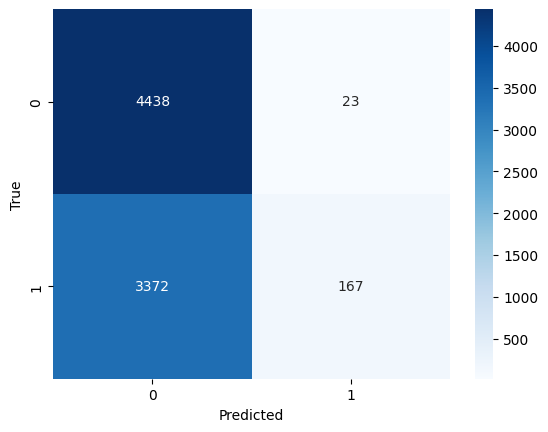

In [ ]:
# Setup
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_triplet_dataset = TripletDataset(train_data, tokenizer)
val_triplet_dataset = TripletDataset(val_data, tokenizer)

train_triplet_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)
val_triplet_loader = DataLoader(val_triplet_dataset, batch_size=32)

triplet_model = TripletNetwork(model_name=model_name)
triplet_loss_fn = TripletLoss(margin=1.0)
triplet_optimizer = torch.optim.Adam(triplet_model.parameters(), lr=2e-5)

# Train
history = train_triplet(triplet_model, triplet_loss_fn, triplet_optimizer, train_triplet_loader, val_triplet_loader, num_epochs=5)

# Load best model
triplet_model.load_state_dict(torch.load("best_triplet_model.pt"))

# Evaluate
evaluate_triplet(triplet_model, val_data, tokenizer, threshold=0.5)
